In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARMA,ARIMA,ARMAResults,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from pmdarima import auto_arima

In [2]:
df = pd.read_excel('prepdata.xlsx',index_col=0,parse_dates=True)
df.dropna(axis='columns',inplace=True)
df.head()

,CO1 Comdty,CO2 Comdty,CO3 Comdty,CO4 Comdty,PVMMDS12 Index,PVMMDS23 Index,PVMMD2M3 Index,PVMMD3M4 Index,PVMMDBSP Index,DKI1 Comdty,...,CFCDQORS Index,CFCDPORL Index,CFCDPORS Index,CFCDQPTS Index,CFCDQSWD Index,CFCDPMMD Index,OISTCRDE Index,GBPUSD Curncy,EURUSD Curncy,JPYUSD Curncy
2018-01-02,66.57,66.13,65.79,65.51,0.25,0.25,0.25,0.25,3.08,64.01,...,55237,36753,39940,70,388157,47687,2480,1.3590,1.2059,0.008906
2018-01-03,67.84,67.29,66.90,66.57,0.26,0.26,0.26,0.26,3.36,65.24,...,55237,36753,39940,70,388157,47687,2526,1.3516,1.2015,0.008888
2018-01-04,68.07,67.51,67.11,66.77,0.29,0.29,0.29,0.29,3.34,65.30,...,55237,36753,39940,70,388157,47687,2539,1.3551,1.2068,0.008869
2018-01-05,67.62,67.10,66.73,66.41,0.28,0.26,0.28,0.26,3.29,64.93,...,55237,36753,39940,70,388157,47687,2539,1.3571,1.2029,0.008844
2018-01-08,67.78,67.31,66.95,66.64,0.26,0.24,0.26,0.24,3.24,65.09,...,55237,36753,39940,70,388157,47687,2538,1.3568,1.1967,0.008842


In [40]:
df1 = df[['PVMPGDM1 Index','PVMPGDM4 Index']]
df1.index.freq = 'B'

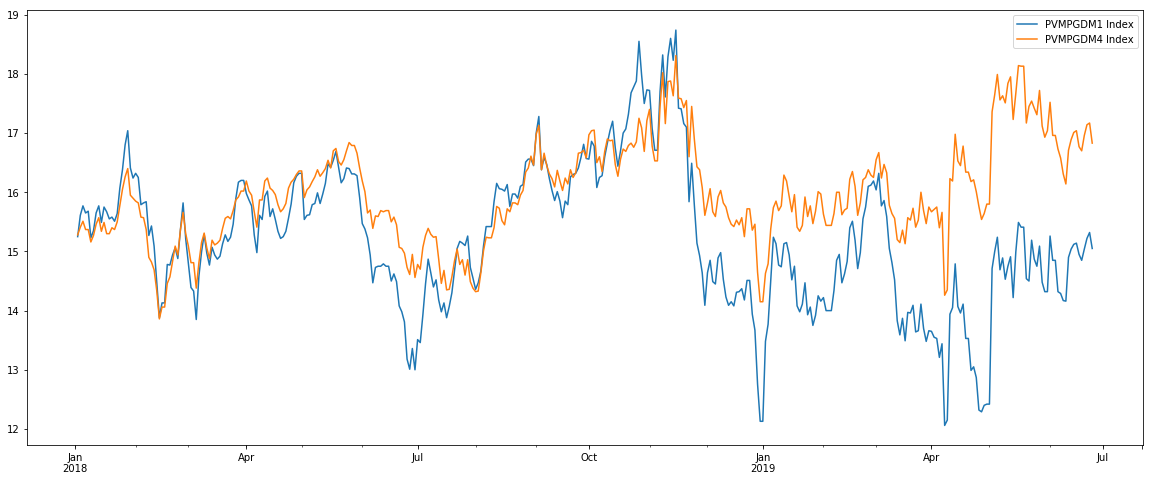

In [41]:
df1.plot(figsize=(20,8),legend=True);

In [5]:
price_index = 'PVMPGDM4 Index'

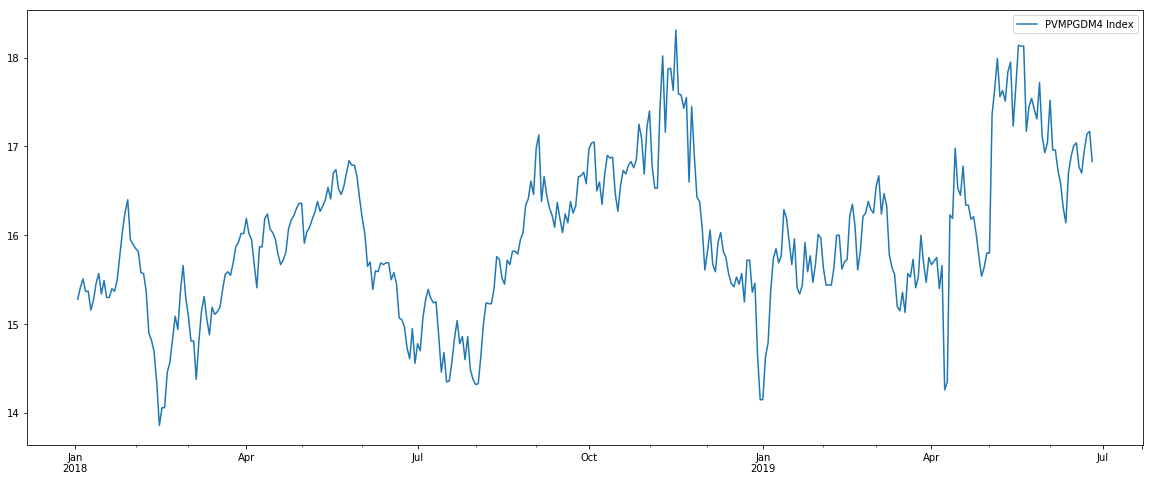

In [6]:
df1[price_index].plot(figsize=(20,8),legend=True);

## ACF and PAFC plot

In [7]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

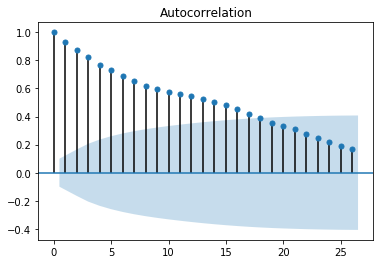

In [8]:
lag = 15
plot_acf(df1[price_index]);

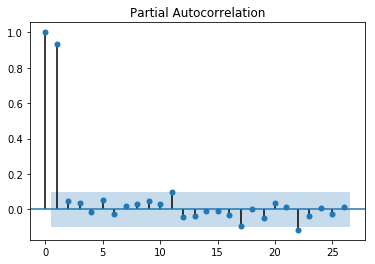

In [9]:
plot_pacf(df1[price_index]);

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [11]:
adf_test(df1[price_index])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.643093
p-value                   0.004989
# lags used               0.000000
# observations          385.000000
critical value (1%)      -3.447450
critical value (5%)      -2.869077
critical value (10%)     -2.570785
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

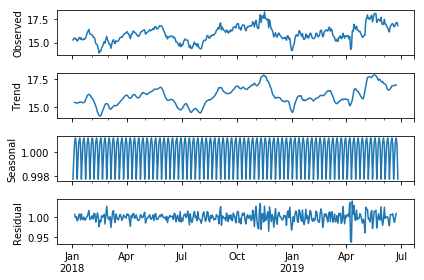

In [13]:
seasonal_decompose(df1[price_index],model='mul').plot();

# Prediction

In [14]:
#Optimize ARIMA parameters
aicVal=[]
for d in range(0,2):
    for ari in range(0,5):
        for maj in range(0,5):
            try:
                arima_obj = ARIMA(df1[price_index].tolist(),order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari,d,maj,arima_obj_fit.aic])
            except ValueError:
                pass

C:\Users\Lenovo\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [15]:
aicVal

[[0, 0, 0, 974.9868097128875],
 [0, 0, 1, 624.6873858000531],
 [0, 0, 2, 471.423015740643],
 [0, 0, 3, 367.96676479502526],
 [0, 0, 4, 324.1652799823154],
 [1, 0, 0, 195.12151971646983],
 [1, 0, 1, 195.83238469103264],
 [1, 0, 2, 197.47234142204616],
 [1, 0, 3, 199.38848303833686],
 [1, 0, 4, 200.47569797823053],
 [2, 0, 0, 195.92016311122063],
 [2, 0, 1, 197.12938357609232],
 [2, 0, 2, 198.43293905205576],
 [2, 0, 3, 200.41880988291712],
 [2, 0, 4, 202.11081574666775],
 [3, 0, 0, 197.4667383916509],
 [3, 0, 1, 198.4036557244416],
 [3, 0, 2, 200.39432234532774],
 [3, 0, 3, 195.98237899121034],
 [3, 0, 4, 197.94477374789506],
 [4, 0, 0, 199.38205229739071],
 [4, 0, 1, 200.3995901649538],
 [4, 0, 2, 201.91045760455938],
 [4, 0, 3, 203.65356822549188],
 [4, 0, 4, 201.19365012353762],
 [0, 1, 0, 204.00623212707603],
 [0, 1, 1, 202.5610518451548],
 [0, 1, 2, 203.05252478664738],
 [0, 1, 3, 204.92303406954943],
 [0, 1, 4, 204.19421630420163],
 [1, 1, 0, 202.97848407587128],
 [1, 1, 1, 194.47

In [16]:
AIC = []
for i,j,k,x in aicVal:
    AIC.append(x)

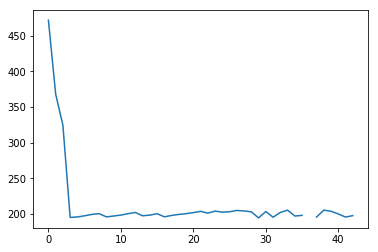

In [17]:
plt.plot(AIC[2:])

In [18]:
auto_arima(df1[price_index],start_p=0,start_q=0,max_p=2,max_d=2,max_q=5,seasonal = False,trace=True).summary()

Fit ARIMA: order=(0, 1, 0); AIC=204.006, BIC=211.913, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 0); AIC=202.978, BIC=214.838, Fit time=0.041 seconds
Fit ARIMA: order=(0, 1, 1); AIC=202.561, BIC=214.421, Fit time=0.032 seconds
Fit ARIMA: order=(1, 1, 1); AIC=194.473, BIC=210.286, Fit time=0.290 seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2); AIC=202.172, BIC=225.892, Fit time=0.384 seconds
Fit ARIMA: order=(2, 1, 1); AIC=195.467, BIC=215.234, Fit time=0.415 seconds
Total fit time: 1.203 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  385
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -93.237
Method:                       css-mle   S.D. of innovations              0.307
Date:                Mon, 15 Jul 2019   AIC                            194.473
Time:                        13:52:36   BIC                            210.286
Sample:                             1   HQIC                           200.745
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      2.158      0.032       0.000       0.007
ar.L1.D.y      0.9190      0.021     44.415      0.000       0.878       0.960
ma.L1.D.y     -1.0000      0.007   -140.998      0.000      -1.014      -0.986
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0881           +0.0000j            1.0881            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [19]:
len(df1)

386

In [20]:
#20 Business Day
train = df1.iloc[:366]
test = df1.iloc[366:]

In [37]:
results = ARIMA(train[price_index],order=(1,0,0)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         PVMPGDM4 Index   No. Observations:                  366
Model:                     ARMA(1, 0)   Log Likelihood                 -91.228
Method:                       css-mle   S.D. of innovations              0.310
Date:                Mon, 15 Jul 2019   AIC                            188.456
Time:                        13:53:34   BIC                            200.164
Sample:                    01-02-2018   HQIC                           193.108
                         - 05-28-2019                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   15.9610      0.237     67.386      0.000      15.497      16.425
ar.L1.PVMPGDM4 Index     0.9341      0.019     49.388      0.000       0.897       0.971
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0706           +0.0000j            1.0706            0.0000
-----------------------------------------------------------------------------
"""

In [38]:
start = len(train)
end = len(train) + len(test) - 1

predictions = results.predict(start=start,end=end).rename('ARMA(1,0) Predictions')

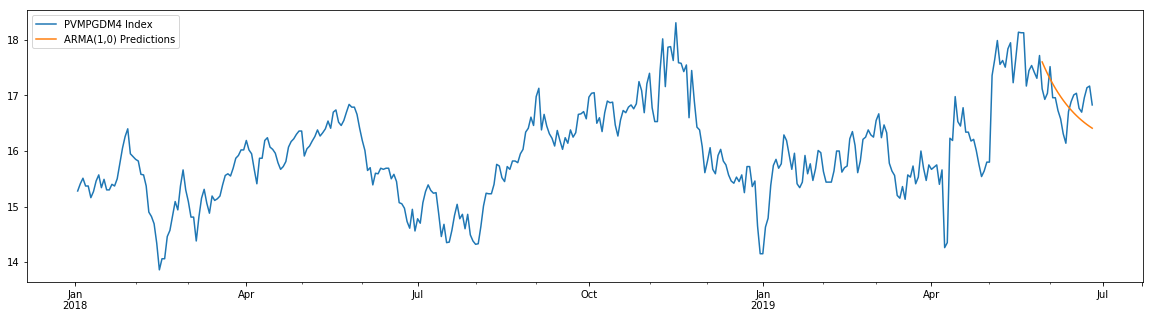

In [39]:
df1[price_index].plot(figsize=(20,5),legend=True)
predictions.plot(legend=True)

In [24]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

error = mean_absolute_error(test[price_index], predictions)
print(f' MAE Error: {error:11.10}') 
error = mean_squared_error(test[price_index], predictions)
print(f' MSE Error: {error:11.10}') 
error = math.sqrt(error)
print(f' RMSE Error: {error:11.10}') 

 MAE Error: 0.3812294576
 MSE Error: 0.1824138299
 RMSE Error: 0.4270993209


# Forecasting

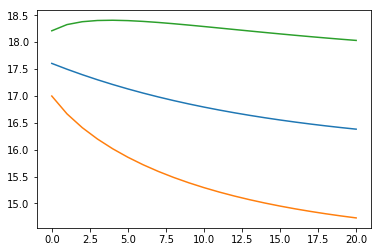

In [25]:
f,err,ci = results.forecast(21)
plt.plot(f)
plt.plot(ci)

In [26]:
upperci = []
lowerci = []
for i,j in ci:
    upperci.append(i)
    lowerci.append(j)

In [27]:
model = ARIMA(df1[price_index],order=(1,0,0))
results = model.fit()
fcast = results.predict(len(df1),len(df1)+20).rename('ARIMA(1,0,0) Forecast')

In [28]:
updata,lowdata = np.array(upperci),np.array(lowerci)
upci,lowci = pd.Series(updata,index=fcast.index).rename('Lower CI'),pd.Series(lowdata,index=fcast.index).rename('Upper CI')

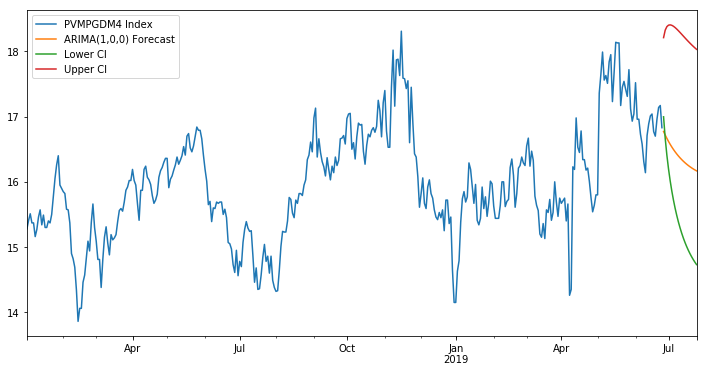

In [29]:
ax = df1[price_index].plot(legend=True,figsize=(12,6))
fcast.plot(legend=True)
upci.plot(legend=True)
lowci.plot(legend=True)
ax.autoscale(axis='x',tight=True)

# Differencing

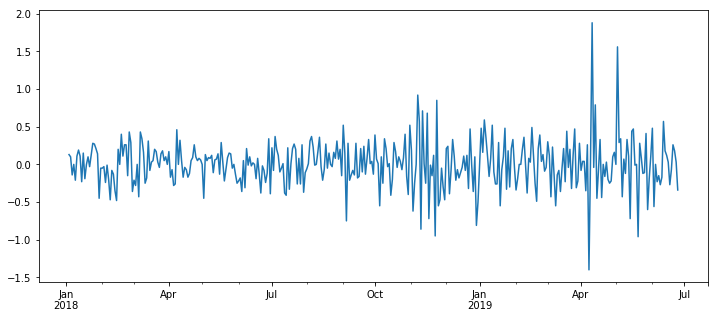

In [30]:
from statsmodels.tsa.statespace.tools import diff

df1['d1'] = diff(df1[price_index],k_diff=1)
df1['d1'].plot(figsize=(12,5));

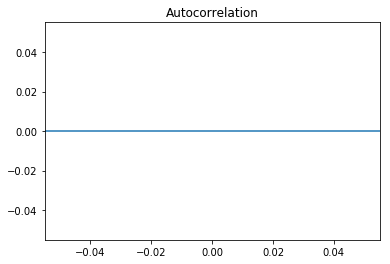

In [31]:
lag = 40
plot_acf(df1['d1']);

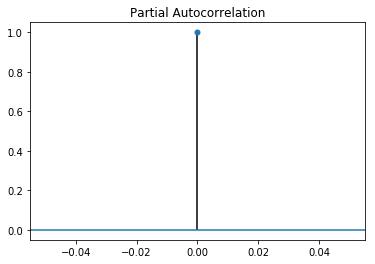

In [32]:
plot_pacf(df1['d1']);

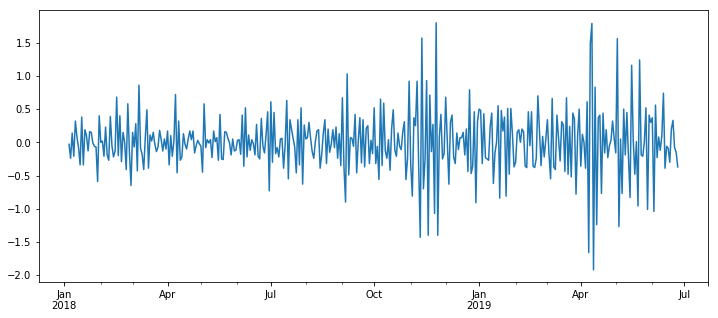

In [33]:
df1['d2'] = diff(df1[price_index],k_diff=2)
df1['d2'].plot(figsize=(12,5));